### Name：Yanwen Wang 

### USCID：2233030502

In [160]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
random.seed(6)

In [161]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [162]:
def fn_generate_cov(dim, corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar, corr)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [163]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

  $Y = \tau * T + c * Z + d * W + e$
  
  covariates: $Z,W$
  
  An example of a real-life situation: I want to know the influence of temperature on precipitation, but variables such as altitude,    longitude and latitude and local humidity will also affect precipitation.
  
  T - temperature, Z - altitude, W - humidity,  Y - precipitation.

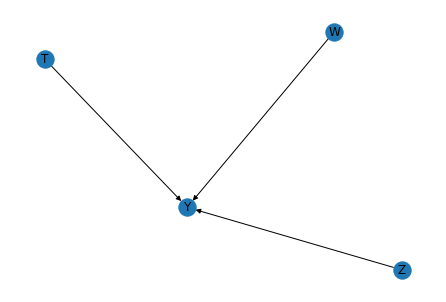

In [164]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='Z')
G.add_node('s4', desc='W')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
G.add_edge('s4','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [166]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.5*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [167]:
tau = 0.5
corr = 0.5
conf = False
p = 3
p0 = 2
flagX = 1
N = 1000
Yab, T, X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
dt1 =  pd.DataFrame(np.concatenate([Yab, T, X],axis=1),columns=['Yab','T','X1','X2','X3'])
dt1.to_csv('1.csv')

In [168]:
# Not control covariates
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yab[np.where(T==1)[0],:]
        Yc = Yab[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.92it/s]


In [169]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.1293422669296599, RMSE=2.333357697203625, size=0.063
N=1000: bias=-0.007884526245269462, RMSE=0.7218222299307855, size=0.05


In [170]:
# Control covariates
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        X_obs = X[:,:p0]
        covars = np.concatenate([T,X_obs],axis = 1)
        mod = sm.OLS(Yab,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.77it/s]


In [171]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.004978260572005676, RMSE=0.14372161607701409, size=0.052
N=1000: bias=-0.0002179656048860909, RMSE=0.045582259242520295, size=0.055


From the results, when the sample size is large(=1000), the difference between the true and estimated values is small.

## 2. Simulate a DGP with a confounder (common cause)

   $Y= e + \tau * T +  0.5 * Z$
   
   $T = c + 0.2 * Z$
   
   An example of a real-life situation:
   
   Y - Income level , Z - Family background , T - Educational background 

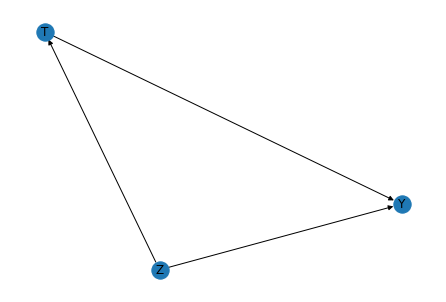

In [172]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='Z')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [173]:
def generate_data_confounder(tau,N,p,corr):
    nvar = p+1 
    corr = 0.5 # correlation for multivariate normal
    allX = fn_generate_multnorm(N,corr,nvar)
    Z = allX[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    e = np.random.normal(0,1,[N,1])
    Yab = tau * T + 0.5 * Z + e
    Tab = T + 0.2 * Z

    return (Yab,Tab,Z)

In [174]:
tau = 2
corr = 0.5
N = 1000
p = 3

Yab, Tab, Z = generate_data_confounder(tau,N,p,corr)
dt2 =  pd.DataFrame(np.concatenate([Yab, Tab, Z],axis=1),columns=['Yab','Tab','Z'])
dt2.to_csv('2.csv')

In [175]:
# Not control confounder
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,Tab,Z = generate_data_confounder(tau,N,p,corr)
        covars = np.concatenate([Tab],axis = 1)
        mod = sm.OLS(Yab,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.80it/s]


In [176]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.03745875141613402, RMSE=0.14164599412456516, size=0.063
N=1000: bias=0.03697594915576328, RMSE=0.058822330009760754, size=0.161


In [177]:
# Control confounder
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,Tab,Z = generate_data_confounder(tau,N,p,corr)
        covars = np.concatenate([Tab,Z],axis = 1)
        mod = sm.OLS(Yab,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.95it/s]


In [178]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.005802949446942173, RMSE=0.1440820372839961, size=0.058
N=1000: bias=0.0003584093066758367, RMSE=0.044866152454959764, size=0.047


From the results, when the sample size is large(=1000), the difference between the true and estimated values is small.

## 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome).

  $Y = e + \tau * T$ 
  
  $Z = c + 0.3 * T + 0.6 * Y$
  
  An example of a real-life situation: I want to know the effect of job performance on salary, and effort has an impact on both job performance and salary.
  
  T - Effort,
  Y - Job Performance,
  Z - Salary increase

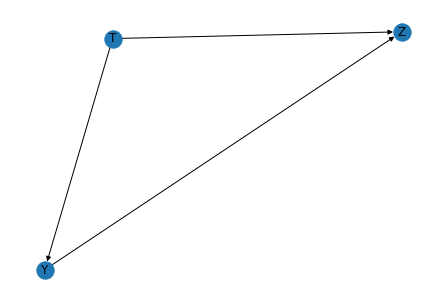

In [179]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Z')
G.add_node('s2', desc='Y')
G.add_node('s3', desc='T')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
G.add_edge('s3','s2')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [180]:
def generate_data_select_bias(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
     
    T = fn_randomize_treatment(N) # choose treated units
    e = np.random.normal(0,1,[N,1])
    c = np.random.normal(0,1,[N,1])
    Yab = e + tau * T
    Zab = c + 0.3 * T + 0.6 * Yab

    return (Yab,T,Zab)

In [181]:
tau = 0.5
corr = 0.5
N = 1000
p = 3
Yab,T,Zab = generate_data_select_bias(tau,N,p,corr)
dt3 =  pd.DataFrame(np.concatenate([Yab,T,Zab],axis=1),columns=['Yab','T','Zab'])
dt3.to_csv('3.csv')

In [182]:
# Not control selection bias
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,Zab = generate_data_select_bias(tau,N,p,corr)   
        Yt = Yab[np.where(T==1)[0],:]
        Yc = Yab[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.53it/s]


In [183]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.008128455440121753, RMSE=0.1994348480539596, size=0.051
N=1000: bias=0.0021281554569362506, RMSE=0.06401246797571014, size=0.055


In [184]:
# Control selection bias
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,Zab = generate_data_select_bias(tau,N,p,corr)
        covars = np.concatenate([T,Zab],axis = 1)
        mod = sm.OLS(Yab,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.61it/s]


In [185]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.2682140117357092, RMSE=0.2981617529806191, size=0.57
N=1000: bias=-0.26393932517417545, RMSE=0.2668428930736104, size=1.0


## 4. Simulate a DGP where the outcome variable is overrepresented at 0.
   
   $Y = 0 * T + 0.6 * X + e$
   
   An example of a real-life situation: I want to know the relationship between height and income.
   
   T - height, X - ability, Y - income.

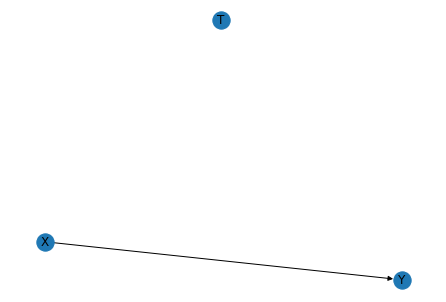

In [186]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='X')
G.add_node('s3', desc='T')
G.add_edge('s2','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [187]:
tau = 0
corr = 0.5
conf = False
p = 3
p0 = 2
flagX = 1
N = 1000
Yab, T, X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
dt1 =  pd.DataFrame(np.concatenate([Yab, T, X],axis=1),columns=['Yab','T','X1','X2','X3'])
dt1.to_csv('4.csv')

In [188]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yab[np.where(T==1)[0],:]
        Yc = Yab[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.16it/s]


In [189]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.10792731208604694, RMSE=2.231613578830298, size=0.057
N=1000: bias=-0.004411062386481764, RMSE=0.7139318705487359, size=0.044
